## Config

In [249]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from punisher.common import *

import itertools
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn import preprocessing
import statsmodels.formula.api as smf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Helpers

In [250]:
def plot_AB(y1, y2, x=None, fs=(20,12), title=None):
    if x is None:
        x = np.array([i for i in range(len(y1))])
    fig, ax = plt.subplots()
    fig.set_size_inches(fs)
    plt.title(title)
    plt.plot(x, y1, label='preds')
    plt.plot(x, y2, label='targs')
    plt.grid()
    legend = ax.legend(loc='upper left')
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Data Feed

In [251]:
# https://coinmarketcap.com/api/
exchange_id = ex_cfg.POLONIEX
asset = Asset(coins.ETH, coins.BTC)
start = datetime.datetime(year=2016, month=1, day=1)
end = datetime.datetime(year=2018, month=1, day=1)
timeframe = Timeframe.THIRTY_MIN
exchange = load_exchange(exchange_id)
#ohlcv_feed.fetch_and_save_asset(exchange, asset, timeframe, start, end)
#feed = OHLCVFileFeed([exchange_id], [asset], timeframe, start, end)
fpath = ohlcv_feed.get_ohlcv_fpath(asset, exchange_id, timeframe)
df = ohlcv_feed.load_asset(fpath)
df.sort_values(by='utc', inplace=True)
df.head()

,open_ETH/BTC_poloniex,high_ETH/BTC_poloniex,low_ETH/BTC_poloniex,close_ETH/BTC_poloniex,volume_ETH/BTC_poloniex,utc
epoch,,,,,,
1451606400,0.002165,0.002170,0.002165,0.002170,2.093664,2016-01-01 00:00:00
1451608200,0.002165,0.002180,0.002165,0.002180,3.874471,2016-01-01 00:30:00
1451610000,0.002165,0.002194,0.002165,0.002188,13.330131,2016-01-01 01:00:00
1451611800,0.002177,0.002188,0.002168,0.002177,0.355722,2016-01-01 01:30:00
1451613600,0.002177,0.002185,0.002168,0.002177,0.169559,2016-01-01 02:00:00


In [252]:
train = df[df['utc'] < datetime.datetime(year=2017, month=9, day=1)]
val = df[df['utc'] >= datetime.datetime(year=2017, month=9, day=1)]
close_col = ohlcv_feed.get_col_name('close', asset.symbol, exchange_id)
volume_col = ohlcv_feed.get_col_name('volume', asset.symbol, exchange_id)

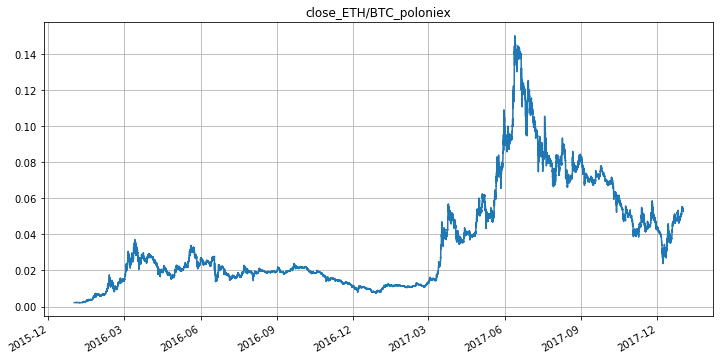

In [253]:
punisher.utils.charts.plot_range(
    df, start=None, end=None, 
    column_name='close_ETH/BTC_'+exchange_id)

## SMA

* https://medium.com/@eliquinox/cryptocurrency-data-analysis-part-iii-backtesting-evaluating-and-optimising-a-trading-strategy-9bc9b1179a8b
* https://www.investopedia.com/university/movingaverage/movingaverages4.asp
* https://blog.patricktriest.com/analyzing-cryptocurrencies-python/
* https://github.com/AdamStone/cryptrade
* https://pythonprogramming.net/advanced-matplotlib-graphing-charting-tutorial/
* https://www.tradingview.com/script/TuG4VjJX-Crypto-Adjusted-Moving-Average-CAMA/
* https://www.tradingview.com/cryptocurrency-signals/
* https://romanorac.github.io/cryptocurrency/analysis/2017/12/29/cryptocurrency-analysis-with-python-part3.html

In [254]:
sma_df = df.copy()
sma_df.head()

,open_ETH/BTC_poloniex,high_ETH/BTC_poloniex,low_ETH/BTC_poloniex,close_ETH/BTC_poloniex,volume_ETH/BTC_poloniex,utc
epoch,,,,,,
1451606400,0.002165,0.002170,0.002165,0.002170,2.093664,2016-01-01 00:00:00
1451608200,0.002165,0.002180,0.002165,0.002180,3.874471,2016-01-01 00:30:00
1451610000,0.002165,0.002194,0.002165,0.002188,13.330131,2016-01-01 01:00:00
1451611800,0.002177,0.002188,0.002168,0.002177,0.355722,2016-01-01 01:30:00
1451613600,0.002177,0.002185,0.002168,0.002177,0.169559,2016-01-01 02:00:00


In [255]:
sma_df['lead'] = sma_df[close_col].rolling(250).mean()
sma_df['lag'] = sma_df[close_col].rolling(500).mean()

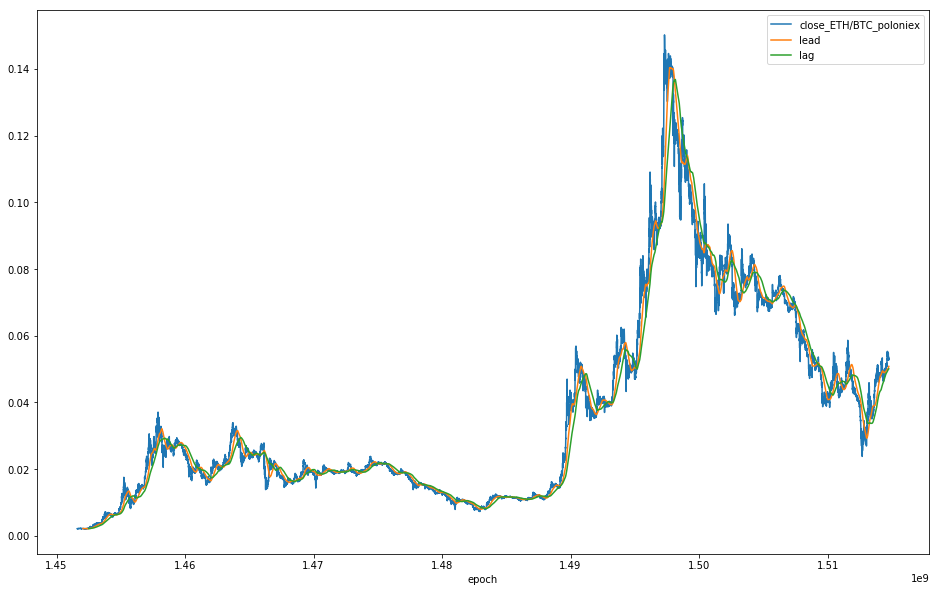

In [256]:
sma_df[[close_col,'lead','lag']].plot(figsize = (16,10))

In [257]:
lead, lag = 1000, 3000
pc_thresh = .025

ma_df = sma_df.copy()
ma_df['lead'] = ma_df[close_col].rolling(lead).mean()
ma_df['lag'] = ma_df[close_col].rolling(lag).mean()
ma_df.dropna(inplace = True)
ma_df['lead-lag'] = ma_df['lead'] - ma_df['lag']
ma_df['pc_diff'] = ma_df['lead-lag'] / ma_df[close_col]
ma_df['regime'] = np.where(ma_df['pc_diff'] > pc_thresh, 1, 0)
ma_df['regime'] = np.where(ma_df['pc_diff'] < -pc_thresh, -1, ma_df['regime'])
ma_df['Market'] = np.log(ma_df[close_col] / ma_df[close_col].shift(1))
ma_df['Strategy'] = ma_df['regime'].shift(1) * ma_df['Market']
ma_df[['Market','Strategy']] = ma_df[['Market','Strategy']].cumsum().apply(np.exp)
ma_df.dropna(inplace=True)

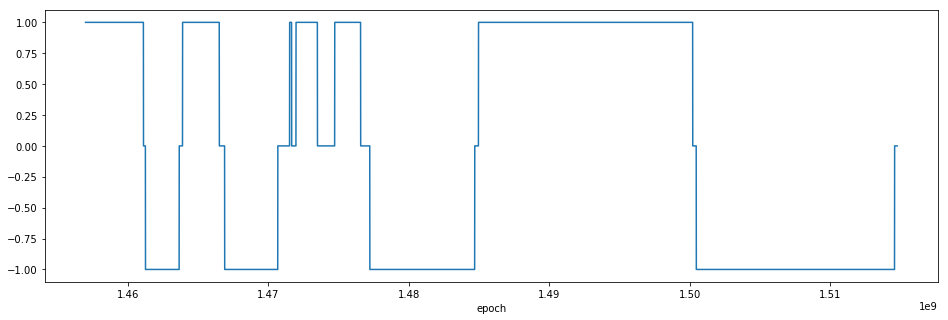

In [258]:
ma_df['regime'].plot(figsize=(16,5))

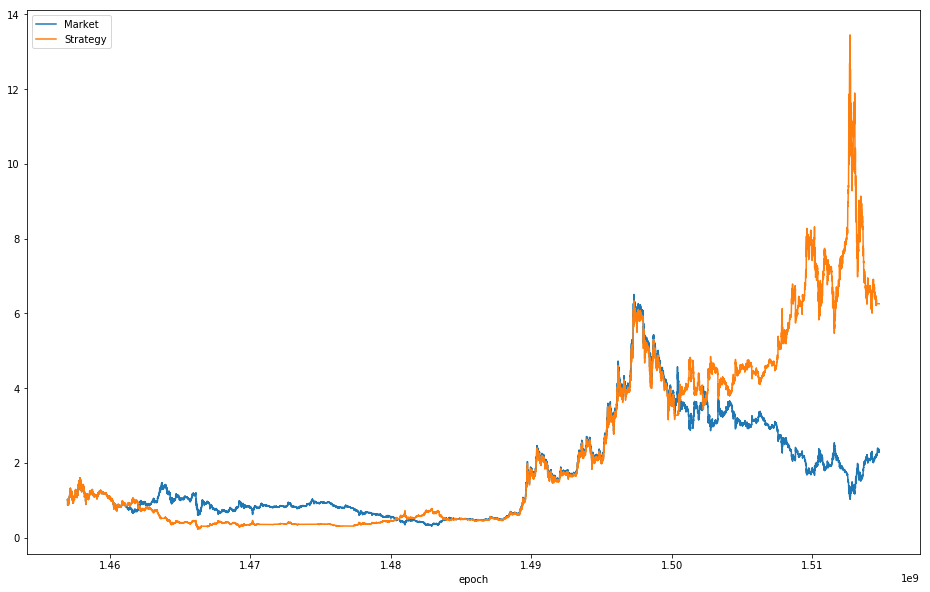

In [259]:
ma_df[['Market','Strategy']].iloc[-1]
ma_df[['Market','Strategy']].plot(figsize = (16,10))

## MACD

* https://romanorac.github.io/cryptocurrency/analysis/2017/12/17/cryptocurrency-analysis-with-python-part1.html

## Linear Regression (OLS)

* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

(35088,)
(29232,) (29232,) (5856,) (5856,)


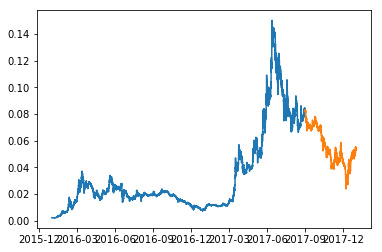

In [260]:
# Numpy Close Data Array
all_utc_arr = np.array(df['utc'])
print(all_utc_arr.shape)

trn_arr = np.array(train[close_col])
trn_utc_arr = np.array(train['utc'])

val_arr = np.array(val[close_col])
val_utc_arr = np.array(val['utc'])
print(trn_arr.shape, trn_utc_arr.shape,val_arr.shape,val_utc_arr.shape)

plt.plot(trn_utc_arr, trn_arr)
plt.plot(val_utc_arr, val_arr)

In [261]:
def get_inp_targs(arr, prior_periods, target_period):
    # Categorical
    # 30 minute timeframe
    # 2 years of data = 35088
    # 48 periods / day
    # Input = 24 periods, output = lower/neutral/higher 
    # (after 12 periods)
    inp = []
    targs = []
    for i in range(0, len(arr[:-target_period])):
        start_close = arr[i]
        end_close = arr[i+target_period]
        pct_delta = (end_close - start_close) / start_close
        inp.append(arr[i:i+prior_periods])
        targs.append(pct_delta)
    inp = np.array(inp)
    targs = np.expand_dims(np.array(targs), axis=1)
    print(inp.shape, targs.shape)
    return inp,targs

In [262]:
trn_inp,trn_targs = get_inp_targs(trn_arr, 12, 24)
val_inp,val_targs = get_inp_targs(val_arr, 12, 24)

(29208, 12) (29208, 1)
(5832, 12) (5832, 1)


In [263]:
linreg = LinearRegression(normalize=True)

linreg.fit(trn_inp, trn_targs)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [264]:
# Intercept and Coefficients
print (linreg.intercept_)
print (linreg.coef_)

[ 0.00572625]
[[-17.47686919  -0.03770166  -0.12383171   0.91777015   0.15289253
    0.45999769  -0.43730455   0.16307367  -0.03758738   0.71400773
    1.03687485  14.60541322]]


In [265]:
# Predict
trn_preds = linreg.predict(trn_inp)
val_preds = linreg.predict(val_inp)
trn_preds.shape, trn_targs.shape, trn_utc_arr.shape

((29208, 1), (29208, 1), (29232,))

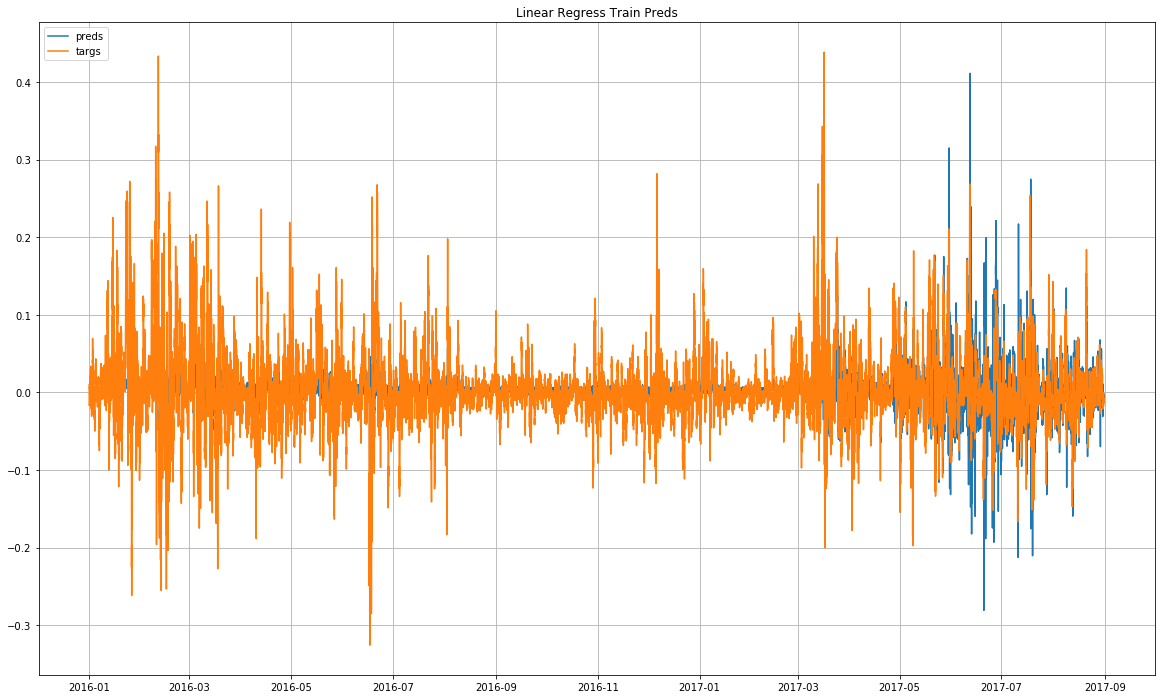

In [266]:
trn_utc_arr = trn_utc_arr[:len(trn_targs)]
plot_AB(trn_preds, trn_targs, x=np.expand_dims(trn_utc_arr,1), 
        title='Linear Regress Train Preds')

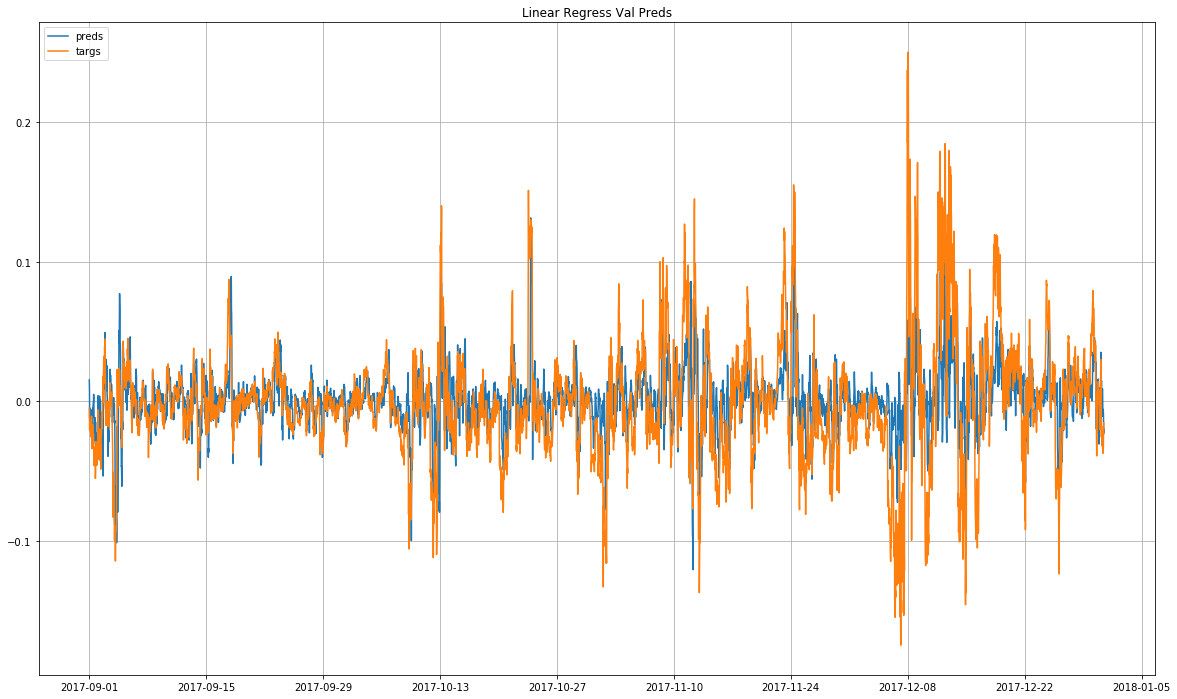

In [267]:
val_utc_arr = val_utc_arr[:len(val_targs)]
plot_AB(val_preds, val_targs, x=np.expand_dims(val_utc_arr,1), title='Linear Regress Val Preds')

In [268]:
# http://www.ritchieng.com/machine-learning-evaluate-linear-regression-model/
print("MAE", metrics.mean_absolute_error(trn_targs, trn_preds))
print("MSE", metrics.mean_squared_error(trn_targs, trn_preds))
print("RMSE", np.sqrt(metrics.mean_squared_error(trn_targs, trn_preds)))

MAE 0.0283015525563
MSE 0.00185860689899
RMSE 0.0431115634023


In [269]:
# http://www.ritchieng.com/machine-learning-evaluate-linear-regression-model/
print("MAE", metrics.mean_absolute_error(val_targs, val_preds))
print("MSE", metrics.mean_squared_error(val_targs, val_preds))
print("RMSE", np.sqrt(metrics.mean_squared_error(val_targs, val_preds)))

MAE 0.020550217771
MSE 0.000980578901134
RMSE 0.0313141964791


## Logistic Regression (Close)

* https://github.com/bfortuner/ml-study/blob/master/LogisticRegression.ipynb

In [270]:
def get_labels(pct_targs, threshold):
    targs = []
    for targ in pct_targs:
        targ = targ[0]
        if targ < -threshold:
            targs.append(0)
        elif targ > threshold:
            targs.append(2)
        else:
            targs.append(1)
    return np.expand_dims(np.array(targs),1)

def get_one_hot_categorical(targs):
    onehots = preprocessing.OneHotEncoder()
    return onehots.fit(targs).transform(targs).toarray()

# trn_onehots = get_one_hot_categorical(trn_targs, .01)
# val_onehots = get_one_hot_categorical(trn_targs, .01)

(35088,)
(29232,) (29232,) (5856,) (5856,)


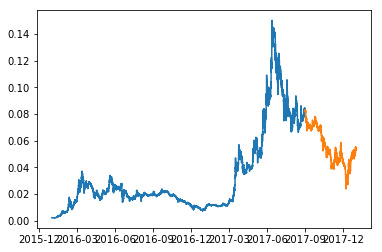

In [271]:
# Numpy Close Data Array
all_utc_arr = np.array(df['utc'])
print(all_utc_arr.shape)

trn_arr = np.array(train[close_col])
trn_utc_arr = np.array(train['utc'])

val_arr = np.array(val[close_col])
val_utc_arr = np.array(val['utc'])
print(trn_arr.shape, trn_utc_arr.shape,val_arr.shape,val_utc_arr.shape)

plt.plot(trn_utc_arr, trn_arr)
plt.plot(val_utc_arr, val_arr)

In [272]:
threshold = .02
trn_inp,trn_targs = get_inp_targs(trn_arr, 12, 24)
val_inp,val_targs = get_inp_targs(val_arr, 12, 24)
trn_labels = get_labels(trn_targs, threshold).ravel()   #Logistic regression expects (n,) shape
val_labels = get_labels(val_targs, threshold).ravel()
normalized_range = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1))
trn_inp = normalized_range.fit_transform(trn_inp)
val_inp = normalized_range.fit_transform(val_inp)

trn_labels.shape,val_labels.shape

(29208, 12) (29208, 1)
(5832, 12) (5832, 1)


((29208,), (5832,))

In [273]:
model = LogisticRegression()
model.fit(trn_inp, trn_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [274]:
# Predict class labels
trn_preds = model.predict(trn_inp)
val_preds = model.predict(val_inp)
trn_preds,val_preds

(array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 0]))

In [275]:
# Predict probabilities
trn_probs = model.predict_proba(trn_inp)
val_probs = model.predict_proba(val_inp)
trn_probs.shape,val_probs.shape

preds = np.argmax(trn_probs,axis=1)
preds

array([1, 1, 1, ..., 1, 1, 1])

In [276]:
# Accuracy
print("Trn Acc", model.score(trn_inp, trn_labels))
print("Val Acc", model.score(val_inp, val_labels))

Trn Acc 0.539886332512
Val Acc 0.657750342936


In [277]:
# Log Loss
print("Trn Cross Entropy", metrics.log_loss(trn_labels, trn_probs))
print("Val Cross Entropy", metrics.log_loss(val_labels, val_probs))

Trn Cross Entropy 0.946773859565
Val Cross Entropy 0.852344812279


In [278]:
np.unique(trn_preds)

array([0, 1, 2])

(array([   884.,  27168.,   1156.]),
 array([ 0.        ,  0.66666667,  1.33333333,  2.        ]),
 <a list of 3 Patch objects>)

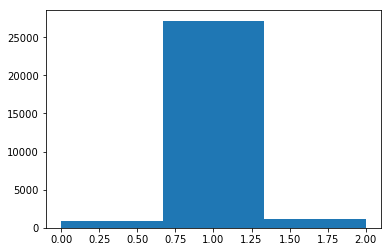

In [279]:
# targets
plt.hist(trn_preds, bins=3, range=(0,2))

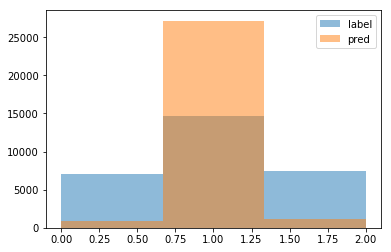

In [280]:
plt.hist(trn_labels, bins=3, alpha=0.5, label='label')
plt.hist(trn_preds, bins=3, alpha=0.5, label='pred')
plt.legend(loc='upper right')
plt.show()

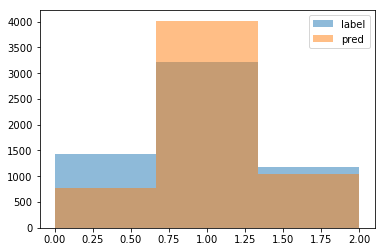

In [281]:
plt.hist(val_labels, bins=3, alpha=0.5, label='label')
plt.hist(val_preds, bins=3, alpha=0.5, label='pred')
plt.legend(loc='upper right')
plt.show()

In [282]:
# Accuracy
print (metrics.accuracy_score(trn_labels, trn_preds))
print (metrics.accuracy_score(val_labels, val_preds))

0.539886332512
0.657750342936


In [283]:
# Classification Report
print (metrics.classification_report(val_labels, val_preds))

             precision    recall  f1-score   support

          0       0.70      0.38      0.49      1437
          1       0.66      0.83      0.74      3212
          2       0.61      0.53      0.57      1183

avg / total       0.66      0.66      0.64      5832



In [284]:
# Confusion Matrix
# https://github.com/bfortuner/ml-study/blob/master/tools/ConfusionMatrix.ipynb 
print (metrics.confusion_matrix(val_labels, val_preds))

[[ 542  841   54]
 [ 197 2662  353]
 [  36  515  632]]


Confusion matrix, without normalization
[[ 542  841   54]
 [ 197 2662  353]
 [  36  515  632]]


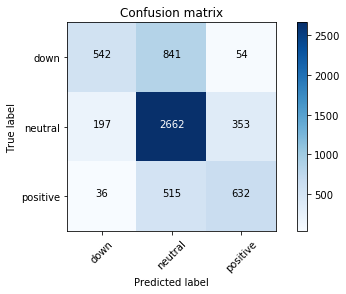

In [285]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(val_labels, val_preds)
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=['down','neutral','positive'],
    title='Confusion matrix')

## Logistic Regression (Close + Volume)

In [287]:
def get_inp_targs(arr, prior_periods, target_period):
    # Categorical
    # 30 minute timeframe
    # 2 years of data = 35088
    # 48 periods / day
    # Input = 24 periods, output = lower/neutral/higher 
    # (after 12 periods)
    inp = []
    targs = []
    for i in range(0, len(arr[:-target_period,:])):
        start_close = arr[i][0]
        end_close = arr[i+target_period][0]
        pct_delta = (end_close - start_close) / start_close
        inp.append(arr[i:i+prior_periods])
        targs.append(pct_delta)
    inp = np.array(inp)
    n_samples, timesteps, cols = inp.shape
    inp = inp.reshape((n_samples, timesteps * cols))
    targs = np.expand_dims(np.array(targs), axis=1)
    print(inp.shape, targs.shape)
    return inp,targs

In [288]:
train = df[df['utc'] < datetime.datetime(year=2017, month=9, day=1)]
val = df[df['utc'] >= datetime.datetime(year=2017, month=9, day=1)]
close_col = ohlcv_feed.get_col_name('close', asset.symbol, exchange_id)
volume_col = ohlcv_feed.get_col_name('volume', asset.symbol, exchange_id)

(35088,)
(29232, 2) (29232,) (5856, 2) (5856,)


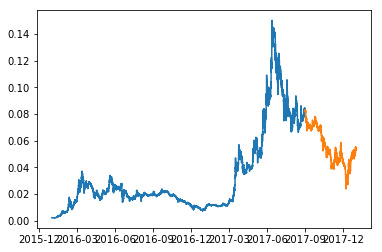

In [289]:
# Numpy Close Data Array
all_utc_arr = np.array(df['utc'])
print(all_utc_arr.shape)

trn_arr = np.array(train[[close_col, volume_col]])
trn_utc_arr = np.array(train['utc'])

val_arr = np.array(val[[close_col, volume_col]])
val_utc_arr = np.array(val['utc'])
print(trn_arr.shape, trn_utc_arr.shape,val_arr.shape,val_utc_arr.shape)

# Price
plt.plot(trn_utc_arr, trn_arr[:,0])
plt.plot(val_utc_arr, val_arr[:,0])

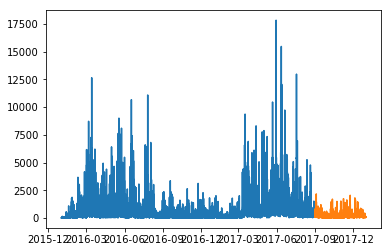

In [290]:
# Volume
plt.plot(trn_utc_arr, trn_arr[:,1])
plt.plot(val_utc_arr, val_arr[:,1])

In [291]:
trn_arr

array([[  2.17019000e-03,   2.09366415e+00],
       [  2.17951000e-03,   3.87447052e+00],
       [  2.18821000e-03,   1.33301311e+01],
       ..., 
       [  8.18399900e-02,   1.60336374e+02],
       [  8.19480400e-02,   2.05298327e+02],
       [  8.19480600e-02,   1.10231886e+02]])

In [292]:
threshold = .02
trn_inp,trn_targs = get_inp_targs(trn_arr, 12, 24)
val_inp,val_targs = get_inp_targs(val_arr, 12, 24)
trn_labels = get_labels(trn_targs, threshold).ravel()   #Logistic regression expects (n,) shape
val_labels = get_labels(val_targs, threshold).ravel()
normalized_range = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1))
trn_inp = normalized_range.fit_transform(trn_inp)
val_inp = normalized_range.fit_transform(val_inp)

(29208, 24) (29208, 1)
(5832, 24) (5832, 1)


In [293]:
model = LogisticRegression()
model.fit(trn_inp, trn_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [294]:
val_arr.shape

(5856, 2)

In [295]:
# Predict class labels
trn_preds = model.predict(trn_inp)
val_preds = model.predict(val_inp)

In [296]:
# Predict probabilities
trn_probs = model.predict_proba(trn_inp)
val_probs = model.predict_proba(val_inp)
trn_probs.shape,val_probs.shape

trn_preds,trn_probs,val_preds,val_probs

(array([1, 1, 1, ..., 1, 1, 1]),
 array([[ 0.19888602,  0.58288893,  0.21822504],
        [ 0.1992398 ,  0.58305363,  0.21770657],
        [ 0.199328  ,  0.58314674,  0.21752526],
        ..., 
        [ 0.23848414,  0.66201658,  0.09949929],
        [ 0.23898898,  0.66082692,  0.10018409],
        [ 0.22313316,  0.67136479,  0.10550206]]),
 array([2, 1, 1, ..., 1, 0, 0]),
 array([[ 0.13543196,  0.376065  ,  0.48850304],
        [ 0.20863744,  0.47569746,  0.3156651 ],
        [ 0.38704298,  0.41269703,  0.20025999],
        ..., 
        [ 0.34940043,  0.49215588,  0.15844369],
        [ 0.49829881,  0.41084245,  0.09085874],
        [ 0.53198513,  0.41210471,  0.05591016]]))

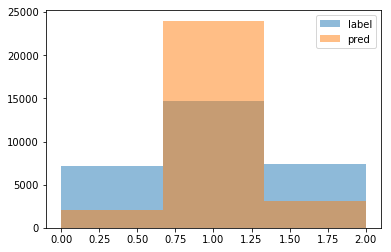

In [297]:
plt.hist(trn_labels, bins=3, alpha=0.5, label='label')
plt.hist(trn_preds, bins=3, alpha=0.5, label='pred')
plt.legend(loc='upper right')
plt.show()

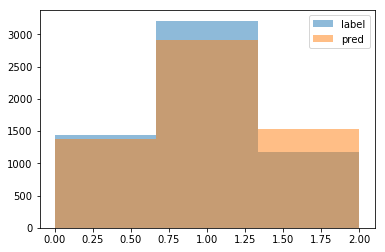

In [298]:
plt.hist(val_labels, bins=3, alpha=0.5, label='label')
plt.hist(val_preds, bins=3, alpha=0.5, label='pred')
plt.legend(loc='upper right')
plt.show()

In [299]:
# Accuracy
print (metrics.accuracy_score(trn_labels, trn_preds))
print (metrics.accuracy_score(val_labels, val_preds))

0.593193645577
0.629115226337


Confusion matrix, without normalization
[[ 1418  5378   311]
 [  442 13634   572]
 [  183  4996  2274]]


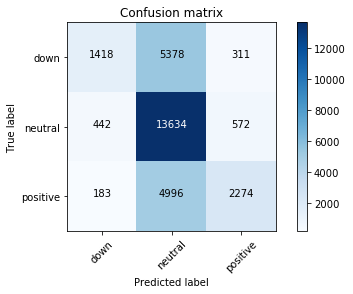

In [300]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(trn_labels, trn_preds)
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=['down','neutral','positive'],
    title='Confusion matrix')

Confusion matrix, without normalization
[[ 784  508  145]
 [ 496 2104  612]
 [  97  305  781]]


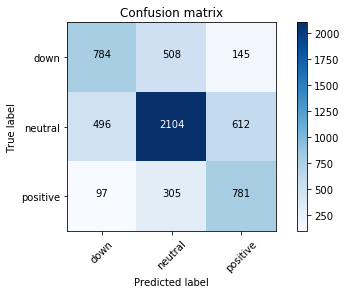

In [301]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(val_labels, val_preds)
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=['down','neutral','positive'],
    title='Confusion matrix')

## SVM

## Random Forest


## Autoencoder

## RNN

## LSTM

## ARIMA

* https://dashee87.github.io/data%20science/general/A-Road-Incident-Model-Analysis/

## Facebook Prophet

* https://github.com/facebook/prophet